## Analyze A/B Test Results


A project that leverages inferential statistics and hypothesis testing in combination with a database of user conversion rates to determine whether a company should adopt a new web page or keep the old one.

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [67]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [68]:
df=pd.read_csv('ab_data.csv')
df.head();

b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [69]:
df_np = df.query('landing_page == "new_page"')
(df_np['group'] != "treatment").sum()

1928

In [70]:
df_op = df.query('landing_page == "old_page"')
(df_op['group'] != "control").sum()

1965

f. Do any of the rows have missing values?

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  we should figure out how we should handle these rows.  

a. They should be removed because we want to be sure about the quality of our data.

In [71]:
df1=df_np[df_np['group'] == "treatment"]
df2=df1.append(df_op[df_op['group'] == "control"]);

In [72]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Clean the data.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2.info()
df2.user_id.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 2 to 294476
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [73]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [74]:
df2.drop(2893,axis=0,inplace=True)

`4.` Investigate the data as follow:

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [75]:
df2[df2['group']=="control"].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [76]:
df2[df2['group']=="treatment"].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [77]:
(df2['landing_page']=="new_page").mean()

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

So far there are not enough evidence to conclude the new page may lead to more conversion. Receiving the new page was fair(p=0.5) for individuals and the conversion rate for new page is slightly smaller than the control group. Thus, we should run a hypothesis test to find out if neither page is better than another.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} <= 0$$


$$H_1: p_{new} - p_{old} > 0$$

or:

$H_{0}$: The likelihood of conversion for a user receiving the new page is less than or equal to the likelihood of conversion for a user receiving the old page.

$H_{1}$: The likelihood of conversion for a user receiving the new page is greater than the likelihood of conversion for a user receiving the old page

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [78]:
pn_obs = df2.query('landing_page == "new_page"').converted.mean()
pn_null = df2.converted.mean()
pn_null

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br>

In [79]:
po_obs = df2.query('landing_page == "old_page"').converted.mean()
po_null = df2.converted.mean()
po_null

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [80]:
nn = df2.query('group == "treatment"').shape[0]
nn

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [81]:
no = df2.query('group == "control"').shape[0]
no

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [82]:
new_page_converted = np.random.choice([0,1],nn,p=[1-pn_null,pn_null])
new_page_converted.mean()

0.12060422544903998

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [83]:
old_page_converted = np.random.choice([0,1],no,p=[1-po_null,po_null])
old_page_converted.mean()

0.11879620579043738

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [84]:
p_diff = new_page_converted.mean()-old_page_converted.mean()
p_diff

0.001808019658602597

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

We can bootstrap to simulate the sampling distrubtion for difference in convertion rate. we can find the standard deviation of the samples to create a standard normal distribution which simulates under the null.

In [81]:
pdif=[]
size = df2.shape[0]
for _ in range(10000):
    b_samp2=df2.sample(size,replace=True)
    pnew = b_samp2.query('landing_page == "new_page"').converted.mean()
    pold = b_samp2.query('landing_page == "old_page"').converted.mean()
    pdif.append(pnew-pold)

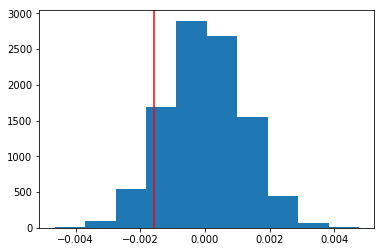

In [82]:
pdif=np.array(pdif)
null_vals = np.random.normal(0,pdif.std(),pdif.size)
plt.hist(null_vals);
plt.axvline(x=obs_diffs, color='r');

We can instead simulate our sampling distribution using binomial distribution as follow:

In [85]:
new_converted_simulation = \
    np.random.binomial(nn, pn_null, 10000)/nn
old_converted_simulation = \
    np.random.binomial(no, po_null, 10000)/no
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

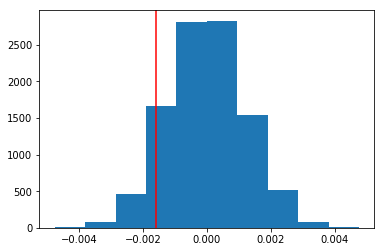

In [86]:
p_diffs=np.array(p_diffs)
obs_diffs = pn_obs-po_obs
plt.hist(p_diffs);
plt.axvline(x=obs_diffs, color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [87]:
pval=(p_diffs>obs_diffs).mean()
pval

0.9027

'''
It is p-value, the probability of the observed change in converted rate occurring or a change even more in favor of an increase in new page conversion rate given there was actually no change in converted rate.
'''

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [71]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"').converted.sum()
convert_new = df2.query('landing_page == "new_page"').converted.sum()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]
convert_old,convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [77]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

In [74]:
from scipy.stats import norm

norm.cdf(z_score)
# 0.9999999383005862 # Tells us how significant our z-score is

norm.ppf(1-(0.05/2))
# 1.959963984540054 # Tells us what our critical value at 95% confidence is

1.959963984540054

In [75]:
norm.cdf(z_score)

0.90505831275902449

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

We applied a one-sided z-test here(using smaller alternative which represent the alternative hypthesis according to [convert_old<convert_new] and since the A/B test in Part II was also one sided according to the null, the p-values reasonably match each other. p-value represent all the null values that are more extreme than our statistic (here:observed difference) in favor of alternative.

Since the z-score of 1.31 is within the range of the critical value, 1.96, we fail to reject the null hypothesis.

Thus, both the built-in method and the manual calculation lead to the same conclusion.